# Monthly Treasury Trade

## Packages

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import sys 
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\MonthlyTreasurySeasonality\root\src")
from MonthlyReturns import MonthlyReturns

In [5]:
df = MonthlyReturns().get_monthly_rtn()

## Returns Playback

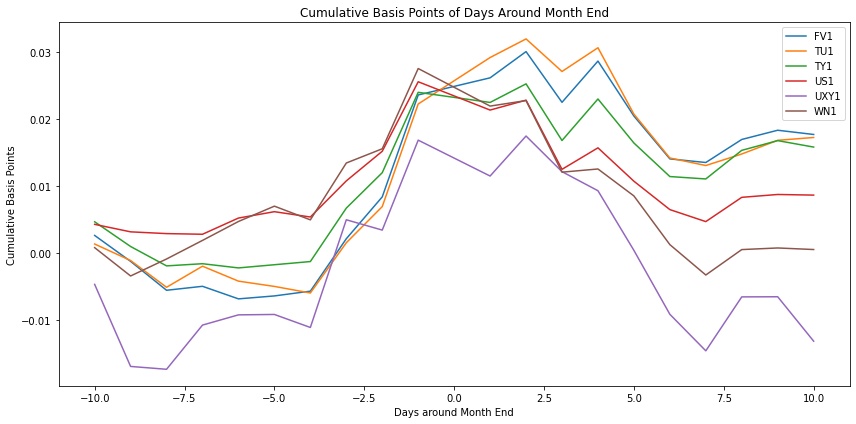

In [38]:
def plot_rtn_around_month_end(df: pd.DataFrame) -> plt.Figure: 
    
    (df.assign(
        days = lambda x: np.where(x.group == "back", -x.days, x.days))
        [["security", "days", "PX_bps"]].
        assign(days = lambda x: x.days.astype(int)).
        groupby(["security", "days"]).
        agg("mean").
        reset_index().
        rename(columns = {"security": ""}).
        pivot(index = "days", columns = "", values = "PX_bps").
        cumsum().
        plot(
            ylabel  = "Cumulative Basis Points",
            xlabel  = "Days around Month End",
            figsize = (12,6),
            title   = "Cumulative Basis Points of Days Around Month End"))
    
    plt.tight_layout()
    
plot_rtn_around_month_end(df)

In [117]:
def get_sharpe(df: pd.DataFrame) -> pd.DataFrame:
    
    df_tmp = (df.assign(
        group_var = lambda x: x.group + " " + x.days.astype(str)))

    group_vars = df_tmp.group_var.drop_duplicates().sort_values().to_list()
    df_out     = pd.DataFrame()

    for group_var in group_vars:

        month_area, days = group_var.split()
        days             = int(days)

        df_add = (df.query(
            "group == @month_area").
            query("days <= @days").
            assign(signal_rtn = lambda x: np.where(month_area == "back", 1, -1) * x.PX_bps)
            [["security", "signal_rtn"]].
            groupby(["security"]).
            agg(["mean", "std"])
            ["signal_rtn"].
            rename(columns = {
                "mean": "mean_rtn",
                "std" : "std_rtn"}).
            assign(
                group      = month_area,
                day_window = days,
                sharpe     = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(12)))

        df_out = pd.concat([df_out, df_add])
        
    return df_out
    
df_sharpe = get_sharpe(df)

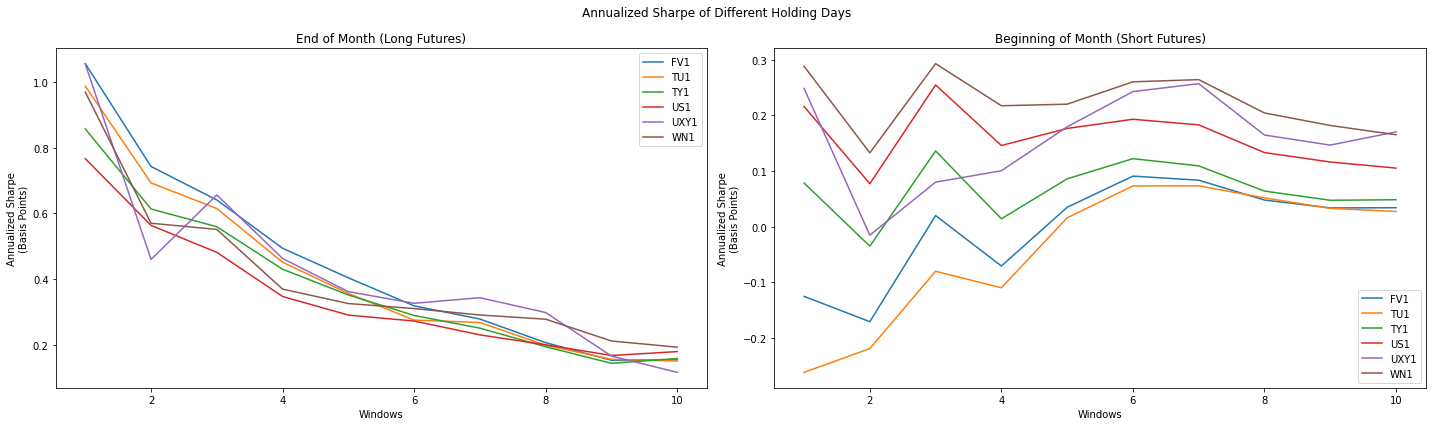

In [131]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    group_vars = df_sharpe.reset_index().group.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars), figsize = (20,6))

    renamer = {
        "back" : "End of Month (Long Futures)",
        "front": "Beginning of Month (Short Futures)"}

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_sharpe.reset_index().query(
            "group == @group_var").
            rename(columns = {"security": ""}).
            pivot(index = "day_window", columns = "", values = "sharpe").
            plot(
                ax     = ax,
                xlabel = "Windows",
                title  = renamer[group_var],
                ylabel = "Annualized Sharpe\n(Basis Points)"))

    fig.suptitle("Annualized Sharpe of Different Holding Days")
    plt.tight_layout()
    
plot_sharpe(df_sharpe)

In [172]:
def get_oos_rtn(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_tmp = (df.assign(
        group_var = lambda x: x.group + " " + x.days.astype(str) + " " + x.security))

    group_vars = df_tmp.group_var.drop_duplicates().sort_values().to_list()
    df_out     = pd.DataFrame()

    for group_var in group_vars:

        month_area, days, security = group_var.split()
        days                       = int(days)

        df_add = (df.query(
            "security == @security").
            query("group == @month_area").
            query("days <= @days").
            sort_values("date").
            assign(
                signal = lambda x: x.PX_bps.expanding().mean().shift(),
                signal_rtn = lambda x: np.sign(x.signal) * x.PX_bps)
            [["date", "security", "signal_rtn", "group"]].
            assign(days = days))

        df_out = pd.concat([df_out, df_add])
        
    return df_out

df_oos_rtn = get_oos_rtn(df)

In [175]:
def get_oos_sharpe(df_oos_rtn: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df_oos_rtn.drop(
        columns = ["date"]).
        groupby(["security", "days", "group"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(12)).
        reset_index())
    
    return df_out

df_oos_sharpe = get_oos_sharpe(df_oos_rtn)

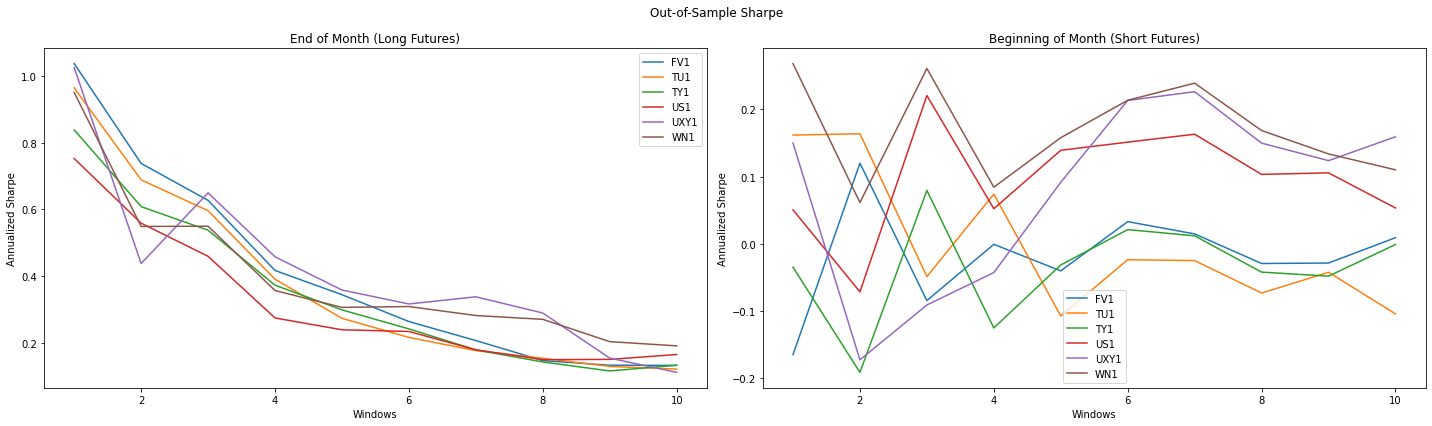

In [190]:
def plot_oos_sharpe(df_oos_sharpe: pd.DataFrame) -> plt.Figure: 
    
    group_vars = df_sharpe.reset_index().group.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars), figsize = (20,6))

    renamer = {
        "back" : "End of Month (Long Futures)",
        "front": "Beginning of Month (Short Futures)"}

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_oos_sharpe.query(
            "group == @group_var").
            rename(columns = {"security": ""}).
            pivot(index = "days", columns = "", values = "sharpe").
            plot(
                ax     = ax,
                xlabel = "Windows",
                ylabel = "Annualized Sharpe",
                title  = renamer[group_var]))

    fig.suptitle("Out-of-Sample Sharpe")
    plt.tight_layout()
    
plot_oos_sharpe(df_oos_sharpe)

In [210]:
def combine_sharpe(df_oos_sharpe: pd.DataFrame, df_sharpe: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df_oos_sharpe[
        ["security", "days", "sharpe", "group"]].
        rename(columns = {
            "days"  : "day_window", 
            "sharpe": "oos_sharpe"}).
        merge(right = df_sharpe, how = "inner", on = ["security", "day_window", "group"]).
        drop(columns = ["mean_rtn", "std_rtn"]).
        rename(columns = {"sharpe": "is_sharpe"}))
    
    return df_out

df_combined = combine_sharpe(df_oos_sharpe, df_sharpe)

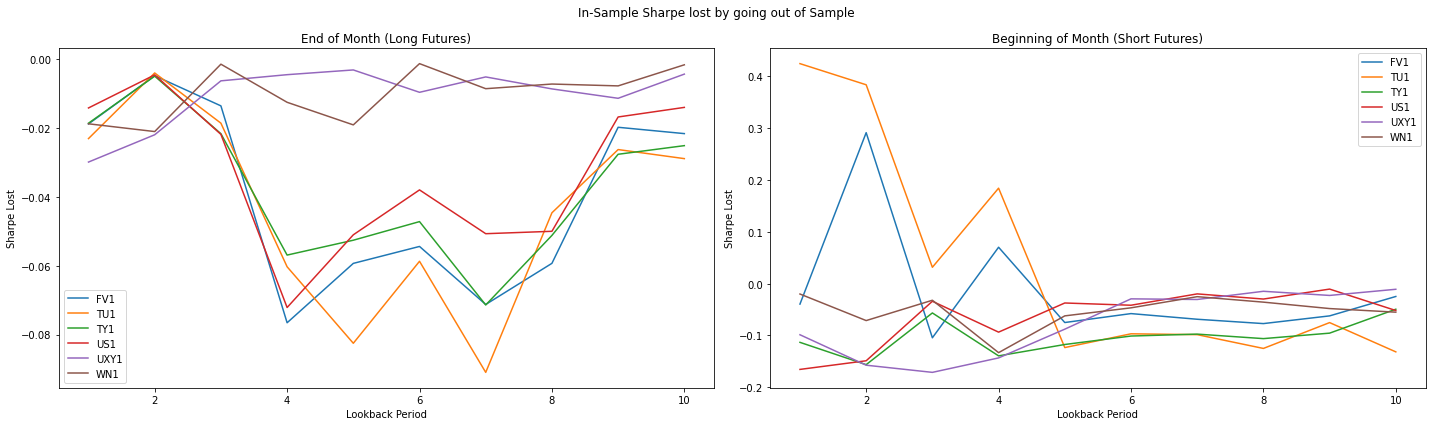

In [226]:
def plot_sharpe_lost(df_combined: pd.DataFrame) -> plt.Figure: 
    
    group_vars = df_sharpe.reset_index().group.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars), figsize = (20,6))

    renamer = {
        "back" : "End of Month (Long Futures)",
        "front": "Beginning of Month (Short Futures)"}

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_combined.assign(
            sharpe_lost = lambda x: x.oos_sharpe - x.is_sharpe).
            rename(columns = {"security": ""}).
            query("group == @group_var").
            pivot(index = "day_window", columns = "", values = "sharpe_lost").
            plot(
                ax     = ax,
                xlabel = "Lookback Period",
                title  = renamer[group_var],
                ylabel = "Sharpe Lost"))

    fig.suptitle("In-Sample Sharpe lost by going out of Sample")
    plt.tight_layout()